# Monte Carlo Nullpoint Approach - Code Description

This code only looks at the Residual Sum of Squares results

# Import Libraries

In [21]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [22]:
#Process Related Options

intEnds = True
randStart = False            #Enables the multistart option for curve_fit
exp_noise = True

# Initialize Parameters and Arrays

In [23]:
#Assumed echo time points

nTE = 64
dTE = 8
TE_series = np.linspace(dTE, dTE*nTE, nTE) #ms units
assert(TE_series[-1] == dTE*nTE)

#SNR Value to Evaluate
SNR_value = 1000

#Parameters that dictate process related features
repetitions = 500     #number of noise realizations averaged


######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6 
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

ub_biX = (1,1,T2_bound,T2_bound)
lb_biX = (-1,-1,0,0)

ub_moX = (1,T2_bound)
lb_moX = (-1,0)

#Multistart Numbers
if randStart:
    biX_4p_starts = 5
    moX_2p_starts = 3
else:
    biX_4p_starts = 1
    moX_2p_starts = 1

#Information determing TI range
nullResolution = 0.5
nullRadius = 20  #20

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

standard_array = np.arange(-nullRadius, nullRadius+0.01, nullResolution)
if intEnds:
    TI1_array = np.floor(TI1star) + standard_array
    TI2_array = np.floor(TI2star) + standard_array
else:
    TI1_array = TI1star + standard_array
    TI2_array = TI2star + standard_array

ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Define Functions

In [24]:
#Defining the function of interest
def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))


In [25]:
def add_noise(data,SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [26]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estimate_NLLS(func, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(func, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    popt = check_param_order(popt)
        
    return popt

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1,-1,0,0)
        upper_bound = (1,1,300,300)
    elif f_name == "S_moX_2p":
        lower_bound = (-1,0)
        upper_bound = (1,300)
    else:
        raise Exception("Not a valid function: " + f_name)
    return lower_bound, upper_bound

def set_p0(lb, ub, TI, func, random = randStart):
    true_params = [T11, T12, c1, c2, T21, T22]
    
    if random:
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        d1 = d_value(TI, c1, T11)
        d2 = d_value(TI, c2, T12)
        if f_name.find("moX") > -1:
            p0 = [(d1+d2)/2,(T21+T22)/2]
        elif f_name.find("biX") > -1:
            p0 = [d1, d2, T21, T22]
        else:
            p0 = true_params
            
    return p0

def multistart_estimate_NLLS(func, tdata, noisey_sig, lb, ub, TI, starts = 1):
    best_RSS = np.inf
    best_params = [] 
    for start in range(starts):
        try:
            init_p = set_p0(lb, ub, TI, func) #This should almost always be a random initial starting location
            hold_popt = estimate_NLLS(func, tdata, noisey_sig, init_p, lb, ub)
            recreated_curve = func(tdata, *hold_popt)
            recreated_curves_RSS = np.sum((noisey_sig - recreated_curve)**2)

            if recreated_curves_RSS < best_RSS:
                best_RSS = recreated_curves_RSS
                best_params = hold_popt
        except Exception as issue:
            print(issue)
            assert(starts>1)
        
    return best_params, best_RSS

In [27]:
def AIC_calc(RSS, n_array, n_params, sigma):

    AIC = 1/len(n_array) * (RSS + 2*n_params*(sigma)**2)

    return AIC

# Theoretical AIC

### RSS Calculations

In [28]:
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_noNoise_moX_TI1 = R0_coeff_TI1 *(TI1_array - TI1star)**2

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_noNoise_moX_TI2 = R0_coeff_TI2 *(TI2_array - TI2star)**2

if exp_noise:
    RSS_noise_biX = (np.size(TE_series)-4)*(1/SNR_value)**2
    RSS_noise_moX = (np.size(TE_series)-2)*(1/SNR_value)**2
    noise_blurb = f"SNR = {SNR_value}"
else:
    RSS_noise_biX = 0
    RSS_noise_moX = 0
    noise_blurb = "noiseless"


RSS_approx_biX = RSS_noise_biX

RSS_approx_moX_TI1 = RSS_noNoise_moX_TI1*(1/dTE) + RSS_noise_moX
RSS_approx_moX_TI2 = RSS_noNoise_moX_TI2*(1/dTE) + RSS_noise_moX

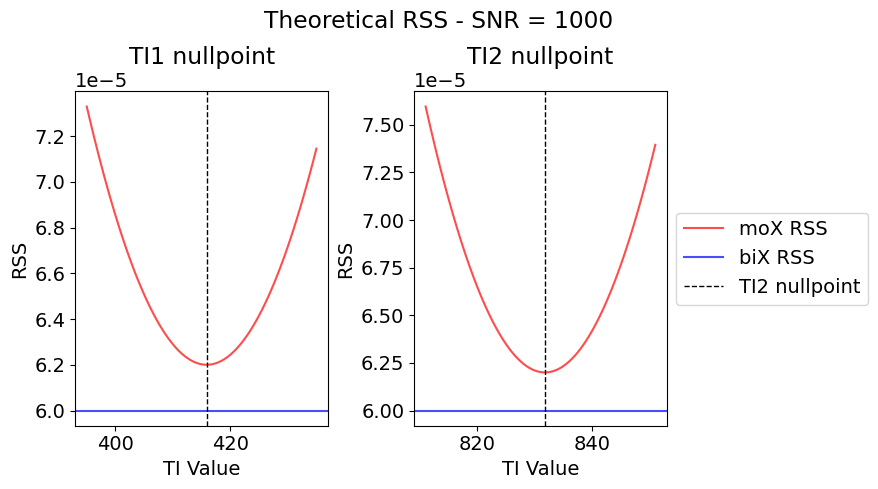

In [29]:
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Theoretical RSS - {noise_blurb}')


ax[0].plot(TI1_array, RSS_approx_moX_TI1, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[0].axhline(y = RSS_approx_biX, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('TI1 nullpoint')

ax[1].plot(TI2_array, RSS_approx_moX_TI2, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[1].axhline(y = RSS_approx_biX, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('TI2 nullpoint')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### AIC

In [30]:
RSS_approx_biX = RSS_noise_biX

RSS_approx_moX_TI1 = RSS_noNoise_moX_TI1*(1/dTE) + RSS_noise_moX
RSS_approx_moX_TI2 = RSS_noNoise_moX_TI2*(1/dTE) + RSS_noise_moX

AIC_biX = AIC_calc(RSS_approx_biX, TE_series, 4, 1/SNR_value)

AIC_moX_TI1 = AIC_calc(RSS_approx_moX_TI1, TE_series, 2, 1/SNR_value)
AIC_moX_TI2 = AIC_calc(RSS_approx_moX_TI2, TE_series, 2, 1/SNR_value)

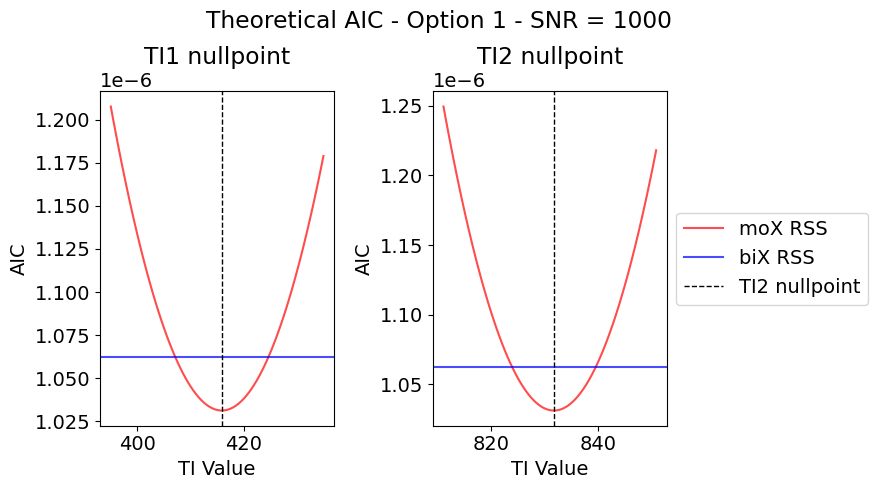

In [31]:
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Theoretical AIC - Option 1 - {noise_blurb}')


ax[0].plot(TI1_array, AIC_moX_TI1, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[0].axhline(y = AIC_biX, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('AIC')
ax[0].set_title('TI1 nullpoint')

ax[1].plot(TI2_array, AIC_moX_TI2, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[1].axhline(y = AIC_biX, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('AIC')
ax[1].set_title('TI2 nullpoint')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Evaluating RSS Shape

In [32]:
slice_radius_TI1 = (2*dTE/(R0_coeff_TI1*SNR_value**2))**(1/2)

low_cross_T1 = TI1star - slice_radius_TI1
high_cross_T1 = TI1star + slice_radius_TI1

slice_radius_TI2 = (2*dTE/(R0_coeff_TI2*SNR_value**2))**(1/2)

low_cross_T2 = TI2star - slice_radius_TI2
high_cross_T2 = TI2star + slice_radius_TI2

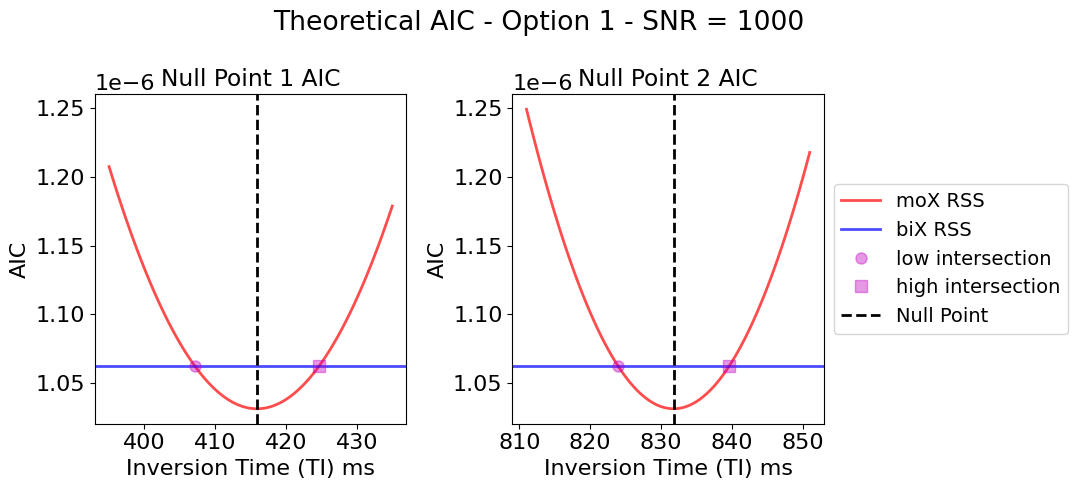

In [33]:
plt.rc('font', size = 16)

fig, ax = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
fig.suptitle(f'Theoretical AIC - Option 1 - {noise_blurb}')

plt.rc('font', size = 14)


ax[0].plot(TI1_array, AIC_moX_TI1, label = 'moX RSS', alpha = 0.7, color = 'r', lw = 2)
ax[0].axhline(y = AIC_biX, label = 'biX RSS', alpha = 0.7, color = 'b', lw = 2)
ax[0].plot(low_cross_T1, AIC_biX, label = "low intersection", alpha = 0.4, color = 'm', marker = 'o', ms = 8, ls = '')
ax[0].plot(high_cross_T1, AIC_biX, label = "high intersection", alpha = 0.4, color = 'm', marker = 's', ms = 8, ls = '')

ax[0].axvline(x=TI1star, linewidth=1, label= 'Null Point', color='k', ls = '--', lw = 2)
ax[0].set_xlabel('Inversion Time (TI) ms')
ax[0].set_ylabel('AIC')
ax[0].set_title('Null Point 1 AIC')


ax[1].plot(TI2_array, AIC_moX_TI2, label = 'moX RSS', alpha = 0.7, color = 'r', lw = 2)
ax[1].axhline(y = AIC_biX, label = 'biX RSS', alpha = 0.7, color = 'b', lw = 2)
ax[1].plot(low_cross_T2, AIC_biX, label = "low intersection", alpha = 0.4, color = 'm', marker = 'o', ms = 8, ls = '')
ax[1].plot(high_cross_T2, AIC_biX, label = "high intersection", alpha = 0.4, color = 'm', marker = 's', ms = 8, ls = '')

ax[1].axvline(x=TI2star, linewidth=1, label= 'Null Point', color='k', ls = '--', lw = 2)
ax[1].set_xlabel('Inversion Time (TI) ms')
ax[1].set_ylabel('AIC')
ax[1].set_title('Null Point 2 AIC')

ymin, ymax = ax[1].get_ylim()

ax[0].set_ylim([ymin,ymax])

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [34]:
SNR_list = np.arange(10,500, 20)

hold_radius_T1 = np.zeros(len(SNR_list))
hold_radius_T2 = np.zeros(len(SNR_list))

for iSNR in range(SNR_list.shape[0]):
    SNR_val = SNR_list[iSNR]
    slice_radius_TI1 = ((2*np.log(nTE)-2)*dTE/(R0_coeff_TI1*SNR_val**2))**(1/2)

    hold_radius_T1[iSNR] = slice_radius_TI1

    slice_radius_TI2 = ((2*np.log(nTE)-2)*dTE/(R0_coeff_TI2*SNR_val**2))**(1/2)

    hold_radius_T2[iSNR] = slice_radius_TI2

    

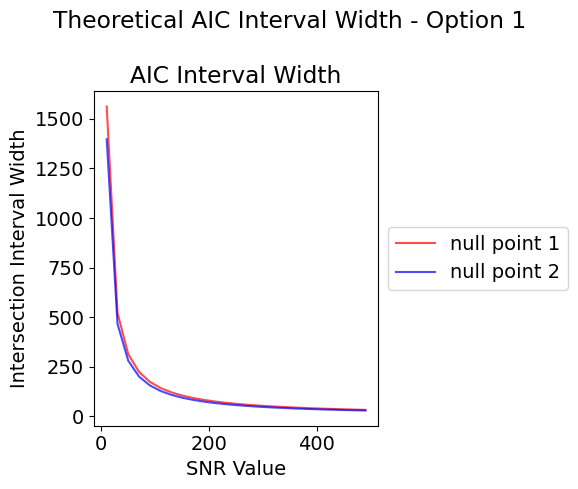

In [35]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Theoretical AIC Interval Width - Option 1')

ax.plot(SNR_list, hold_radius_T1, alpha = 0.7, color = 'r', label = "null point 1")
ax.plot(SNR_list, hold_radius_T2, alpha = 0.7, color = 'b', label = "null point 2")

ax.set_xlabel('SNR Value')
ax.set_ylabel('Intersection Interval Width')
ax.set_title('AIC Interval Width')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

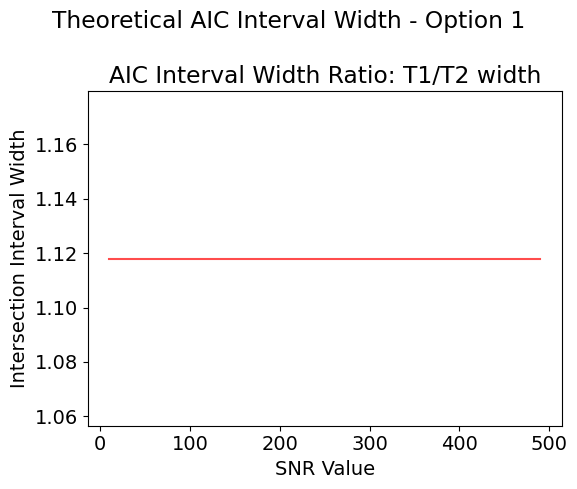

In [41]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Theoretical AIC Interval Width - Option 1')

ax.plot(SNR_list, hold_radius_T1/hold_radius_T2, alpha = 0.7, color = 'r')

ax.set_xlabel('SNR Value')
ax.set_ylabel('Intersection Interval Width')
ax.set_title('AIC Interval Width Ratio: T1/T2 width')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Experimental Comparison

### Data Generation

In [36]:
signal_array_T1 = np.zeros([len(TI1_array), nTE])

for iTI in range(len(TI1_array)):
    signal_array_T1[iTI,:] = S_biX_6p(TE_series, *true_params, TI = TI1_array[iTI])


signal_array_T2 = np.zeros([len(TI2_array), nTE])

for iTI in range(len(TI2_array)):
    signal_array_T2[iTI,:] = S_biX_6p(TE_series, *true_params, TI = TI2_array[iTI])

if exp_noise:
    signal_array_T1 = add_noise(signal_array_T1, SNR_value)
    signal_array_T2 = add_noise(signal_array_T2, SNR_value)
    noise_blurb = f"SNR = {SNR_value}"
else:
    noise_blurb = "noiseless"

### Experimental RSS

In [37]:
lb_4p, ub_4p = get_func_bounds(S_biX_4p)
lb_2p, ub_2p = get_func_bounds(S_moX_2p)

popt_array_T1_4p = np.zeros([signal_array_T1.shape[0], 4])
RSS_array_T1_4p = np.zeros([signal_array_T1.shape[0]])

popt_array_T1_2p = np.zeros([signal_array_T1.shape[0], 2])
RSS_array_T1_2p = np.zeros([signal_array_T1.shape[0]])

for iTI in trange(signal_array_T1.shape[0]):
    noisey_sig = signal_array_T1[iTI,:]
    TI = TI1_array[iTI]
    popt, RSS_opt = multistart_estimate_NLLS(S_biX_4p, TE_series, noisey_sig, lb_4p, ub_4p, TI, starts = biX_4p_starts)
    popt_array_T1_4p[iTI,:] = popt
    RSS_array_T1_4p[iTI] = RSS_opt

    popt, RSS_opt = multistart_estimate_NLLS(S_moX_2p, TE_series, noisey_sig, lb_2p, ub_2p, TI, starts = moX_2p_starts)
    popt_array_T1_2p[iTI,:] = popt
    RSS_array_T1_2p[iTI] = RSS_opt

popt_array_T2_4p = np.zeros([signal_array_T1.shape[0], 4])
RSS_array_T2_4p = np.zeros([signal_array_T1.shape[0]])

popt_array_T2_2p = np.zeros([signal_array_T1.shape[0], 2])
RSS_array_T2_2p = np.zeros([signal_array_T1.shape[0]])

for iTI in trange(signal_array_T2.shape[0]):
    noisey_sig = signal_array_T2[iTI,:]
    TI = TI2_array[iTI]
    popt, RSS_opt = multistart_estimate_NLLS(S_biX_4p, TE_series, noisey_sig, lb_4p, ub_4p, TI, starts = biX_4p_starts)
    popt_array_T2_4p[iTI,:] = popt
    RSS_array_T2_4p[iTI] = RSS_opt

    popt, RSS_opt = multistart_estimate_NLLS(S_moX_2p, TE_series, noisey_sig, lb_2p, ub_2p, TI, starts = moX_2p_starts)
    popt_array_T2_2p[iTI,:] = popt
    RSS_array_T2_2p[iTI] = RSS_opt


  7%|▋         | 6/81 [00:00<00:01, 37.56it/s]

100%|██████████| 81/81 [00:04<00:00, 17.68it/s]


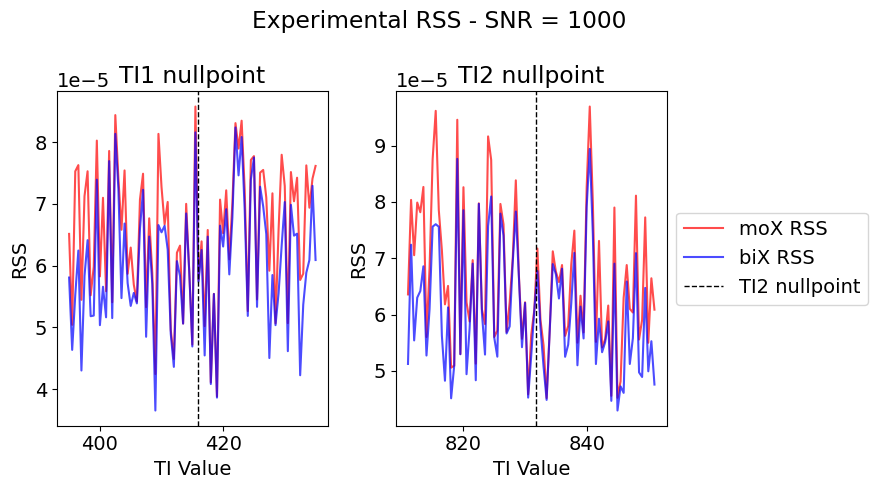

In [38]:
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Experimental RSS - {noise_blurb}')


ax[0].plot(TI1_array, RSS_array_T1_2p, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[0].plot(TI1_array, RSS_array_T1_4p, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('TI1 nullpoint')

ax[1].plot(TI2_array, RSS_array_T2_2p, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[1].plot(TI2_array, RSS_array_T2_4p, label = 'biX RSS', alpha = 0.7, color = 'b')

ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('TI2 nullpoint')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

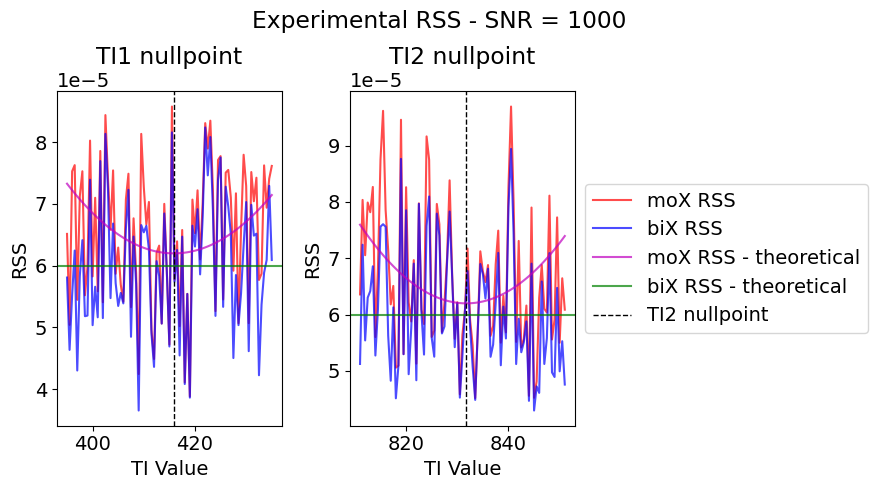

In [39]:
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Experimental RSS - {noise_blurb}')


ax[0].plot(TI1_array, RSS_array_T1_2p, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[0].plot(TI1_array, RSS_array_T1_4p, label = 'biX RSS', alpha = 0.7, color = 'b')
ax[0].plot(TI1_array, RSS_approx_moX_TI1, label = 'moX RSS - theoretical', alpha = 0.7, color = 'm')
ax[0].axhline(y = RSS_approx_biX, label = 'biX RSS - theoretical', alpha = 0.7, color = 'g')

ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('TI1 nullpoint')

ax[1].plot(TI2_array, RSS_array_T2_2p, label = 'moX RSS', alpha = 0.7, color = 'r')
ax[1].plot(TI2_array, RSS_array_T2_4p, label = 'biX RSS', alpha = 0.7, color = 'b')
ax[1].plot(TI2_array, RSS_approx_moX_TI2, label = 'moX RSS - theoretical', alpha = 0.7, color = 'm')
ax[1].axhline(y = RSS_approx_biX, label = 'biX RSS - theoretical', alpha = 0.7, color = 'g')


ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('TI2 nullpoint')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Iteration Experiment

In [20]:
lb_4p, ub_4p = get_func_bounds(S_biX_4p)
lb_2p, ub_2p = get_func_bounds(S_moX_2p)

RSS_array_T1_4p = np.zeros([repetitions, signal_array_T1.shape[0]])
RSS_array_T1_2p = np.zeros([repetitions, signal_array_T1.shape[0]])
RSS_array_T2_4p = np.zeros([repetitions, signal_array_T1.shape[0]])
RSS_array_T2_2p = np.zeros([repetitions, signal_array_T1.shape[0]])

for rep in trange(repetitions):
    signal_array_T1 = np.zeros([len(TI1_array), nTE])

    for iTI in range(len(TI1_array)):
        signal_array_T1[iTI,:] = S_biX_6p(TE_series, *true_params, TI = TI1_array[iTI])

    signal_array_T2 = np.zeros([len(TI2_array), nTE])

    for iTI in range(len(TI2_array)):
        signal_array_T2[iTI,:] = S_biX_6p(TE_series, *true_params, TI = TI2_array[iTI])

    signal_array_T1 = add_noise(signal_array_T1, SNR_value)
    signal_array_T2 = add_noise(signal_array_T2, SNR_value)


    for iTI in range(signal_array_T1.shape[0]):
        noisey_sig = signal_array_T1[iTI,:]
        TI = TI1_array[iTI]
        _, RSS_opt = multistart_estimate_NLLS(S_biX_4p, TE_series, noisey_sig, lb_4p, ub_4p, TI, starts = biX_4p_starts)
        RSS_array_T1_4p[rep, iTI] = RSS_opt

        _, RSS_opt = multistart_estimate_NLLS(S_moX_2p, TE_series, noisey_sig, lb_2p, ub_2p, TI, starts = moX_2p_starts)
        RSS_array_T1_2p[rep, iTI] = RSS_opt

    for iTI in range(signal_array_T2.shape[0]):
        noisey_sig = signal_array_T2[iTI,:]
        TI = TI2_array[iTI]
        _, RSS_opt = multistart_estimate_NLLS(S_biX_4p, TE_series, noisey_sig, lb_4p, ub_4p, TI, starts = biX_4p_starts)
        RSS_array_T2_4p[rep, iTI] = RSS_opt

        _, RSS_opt = multistart_estimate_NLLS(S_moX_2p, TE_series, noisey_sig, lb_2p, ub_2p, TI, starts = moX_2p_starts)
        RSS_array_T2_2p[rep, iTI] = RSS_opt


  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 6/500 [00:58<1:19:42,  9.68s/it]


KeyboardInterrupt: 

In [ ]:
RSS_array_T1_4p_avg = np.mean(RSS_array_T1_4p, axis = 0)
RSS_array_T1_2p_avg = np.mean(RSS_array_T1_2p, axis = 0)
RSS_array_T2_4p_avg = np.mean(RSS_array_T2_4p, axis = 0)
RSS_array_T2_2p_avg = np.mean(RSS_array_T2_2p, axis = 0)

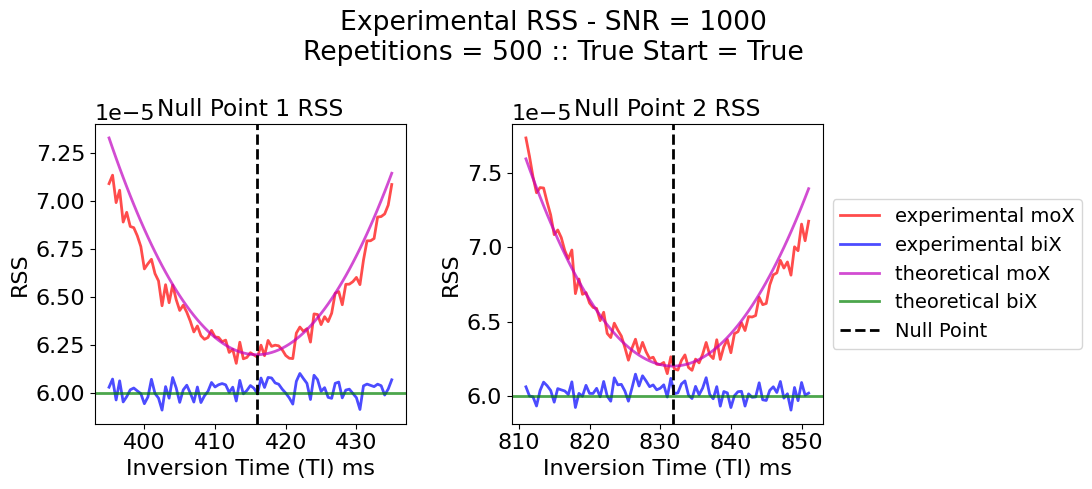

In [ ]:
plt.rc('font', size = 16)

fig, ax = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
fig.suptitle(f'Experimental RSS - {noise_blurb}\nRepetitions = {repetitions} :: True Start = {not randStart}')

plt.rc('font', size = 14)

ax[0].plot(TI1_array, RSS_array_T1_2p_avg, label = 'experimental moX', alpha = 0.7, color = 'r', lw = 2)
ax[0].plot(TI1_array, RSS_array_T1_4p_avg, label = 'experimental biX', alpha = 0.7, color = 'b', lw = 2)
ax[0].plot(TI1_array, RSS_approx_moX_TI1, label = 'theoretical moX', alpha = 0.7, color = 'm', lw = 2)
ax[0].axhline(y = RSS_approx_biX, label = 'theoretical biX', alpha = 0.7, color = 'g', lw = 2)

ax[0].axvline(x=TI1star, linewidth=1, label= 'Null Point', color='k', ls = '--', lw = 2)
ax[0].set_xlabel('Inversion Time (TI) ms')
ax[0].set_ylabel('RSS')
ax[0].set_title('Null Point 1 RSS')

ax[1].plot(TI2_array, RSS_array_T2_2p_avg, label = 'experimental moX', alpha = 0.7, color = 'r', lw = 2)
ax[1].plot(TI2_array, RSS_array_T2_4p_avg, label = 'experimental biX', alpha = 0.7, color = 'b', lw = 2)
ax[1].plot(TI2_array, RSS_approx_moX_TI2, label = 'theoretical moX', alpha = 0.7, color = 'm', lw = 2)
ax[1].axhline(y = RSS_approx_biX, label = 'theoretical biX', alpha = 0.7, color = 'g', lw = 2)


ax[1].axvline(x=TI2star, linewidth=1, label= 'Null Point', color='k', ls = '--', lw = 2)
ax[1].set_xlabel('Inversion Time (TI) ms')
ax[1].set_ylabel('RSS')
ax[1].set_title('Null Point 2 RSS')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()